In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

import os
import numpy as np
import matplotlib.pyplot as plt

# File Loading of PC/PS

This is slightly annoying because the `Om` is not the same. I have to do some string manipulation.
1. For each file in the PS directory, look for the counterpart in the PC directory.
2. Load the data into lists where for index i, PS[i] and PC[i] come from the same model.

In [2]:
# I'm running this locally, change to /tigress/jialiu/zack/ if you're on tigress
data_dir = '/Users/zequnl/Projects/neutrino_mpk/'
PS_directory = data_dir + 'powerspectrum'
PC_directory = data_dir + 'peakcounts'

# this code finds all the filenames and puts them in a list,
# BUT ONLY FOR z05, we'll load in the rest separately 
PS_names, PC_names = [], []
for filename in os.listdir(PS_directory):
    if filename.endswith("_z05.npy"):  
        PS_names.append(filename)
for filename in os.listdir(PC_directory):
    if filename.endswith("_z05.npy"): 
        PC_names.append(filename)
print('Found', len(PS_names), 'PS files and', len(PC_names), 'PC files.')

def get_As( string_with_As ):
    return float(string_with_As.split('_As')[1].split('_mva')[0])

def get_filenames_PS_PC( input_As ):
    PS_filename_candidates = [x for x in PS_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    PC_filename_candidates = [x for x in PC_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    if len(PS_filename_candidates) == 1 and len(PC_filename_candidates) == 1:
        return PS_filename_candidates[0], PC_filename_candidates[0]
    else:
        print("multiple file candidates found! possibly fiducial model 1a/1b")
        return None

Found 101 PS files and 101 PC files.


In [3]:
from astropy.table import Table
t = Table.read(data_dir + 'cosmological_parameters.txt', format='ascii')

PS_filename_list_temp = []
PC_filename_list_temp = []
for row in t:
    # special cases (fiducial 1 and 2)
    if '1a(fiducial)' in row['Model']:
        PS_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z05.npy'
        PC_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z05.npy'
    elif '1b(fiducial)' in row['Model']:
        PS_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50_z05.npy'
        PC_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S_z05.npy'
    else:
        PS_name, PC_name = get_filenames_PS_PC(row['10^9*A_s'])
    
    PS_filename_list_temp.append(PS_name)
    PC_filename_list_temp.append(PC_name)

# put the filenames in the table for easy access
t['PS'] = np.array(PS_filename_list_temp)
t['PC'] = np.array(PC_filename_list_temp)

# show the table
t

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str86,str85
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z05.npy
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S_z05.npy
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PS_50_z05.npy,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PC_S_z05.npy
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PS_50_z05.npy,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PC_S_z05.npy
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PS_50_z05.npy,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PC_S_z05.npy
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PS_50_z05.npy,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PC_S_z05.npy
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PS_50_z05.npy,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PC_S_z05.npy
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PS_50_z05.npy,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PC_S_z05.npy
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PS_50_z05.npy,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PC_S_z05.npy


## Computing Means and Covariance
We want to use prepare the mean PS and PC here. I just use a bunch of lists. I have to remove the elements which are 0, so I truncate the first 5 off.

In [4]:
PS_means = []
PC_means = []
cutoff_initial_PS = 5
l_min = 200
l_max = 5000

kappa_min = -9.61769831e-03

redshifts = [ '05', '10', '15', '20' ]

for row in t:
    PS_filenames = [ row['PS'].replace('05.npy', r+'.npy') \
                    for r in redshifts ]
    PC_filenames = [ row['PC'].replace('05.npy', r+'.npy') \
                    for r in redshifts ]
    PS_arr = [ np.load( PS_directory + r'/' + filename )[:,:] 
              for filename in PS_filenames ]
    PC_arr = [ np.load( PC_directory + r'/' + filename )[:,:] 
              for filename in PC_filenames ]
    
    # now stack them together sideways
    PS_arr = np.hstack(PS_arr)
    PC_arr = np.hstack(PC_arr)
    
    # filter out ell ranges
    ell = PS_arr[0,:]
    ell_filter = np.logical_and( ell > l_min, ell < l_max )
    
    PS_arr = ((PS_arr.T)[ell_filter]).T
#     PC_arr = ((PC_arr.T)[ell_filter]).T
    
    # first row of PS_arr is ell
    ell = PS_arr[0,:]
    PS_realizations = PS_arr[1:,:]
    
    # first and second row of PC are kappa, SNR
    kappa = PC_arr[0,:]
    PC_arr = ((PC_arr.T)[kappa > kappa_min]).T
    
    kappa = PC_arr[0,:]
    SNR = PC_arr[1,:]
    PC_realizations = PC_arr[2:,:]
    
    if row['Model'] == '1a(fiducial)':
        print('shapes,',PS_realizations.shape, PC_realizations.shape)
        PS_cov = np.cov(PS_realizations.T)
        PC_cov = np.cov(PC_realizations.T)
    
    PS_means.append( np.mean(PS_realizations, axis=0) )
    PC_means.append( np.mean(PC_realizations, axis=0) )


shapes, (1000, 96) (1000, 575)


In [5]:
# for row in [t[0]]:
#     PS_filenames = [ row['PS'].replace('05.npy', r+'.npy') \
#                     for r in redshifts ]
#     PC_filenames = [ row['PC'].replace('05.npy', r+'.npy') \
#                     for r in redshifts ]
#     PS_arr = [ np.load( PS_directory + r'/' + filename )[:,:] 
#               for filename in PS_filenames ]
#     PC_arr = [ np.load( PC_directory + r'/' + filename )[:,:] 
#               for filename in PC_filenames ]
    
#     # now stack them together sideways
#     PS_arr = np.hstack(PS_arr)
#     PC_arr = np.hstack(PC_arr)
#     ell = PS_arr[0,:]
#     PS_realizations = PS_arr[1:,:]
#     print(ell.shape, PS_means[0].shape)
#     plt.plot( ell[ell_filter], PS_means[0], 'ko' )
#     plt.plot( ell[ell_filter], PS_realizations[2,:][ell_filter], 'r.', lw=0.1 )
#     plt.plot( ell[ell_filter], PS_realizations[3,:][ell_filter], 'b.', lw=0.1 )
    
# plt.xscale('log')
# plt.yscale('log')

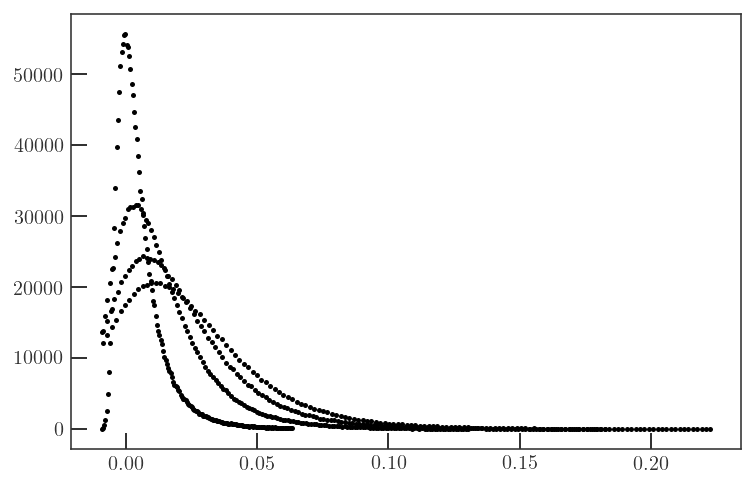

In [6]:
plt.plot( kappa, PC_means[0], 'k.')

## Interpolator

In [7]:
from forecast import buildInterpolator
obsarr = np.array( PS_means ) 
params = np.array( [t['M_nu(eV)'], t['Omega_m'], t['10^9*A_s']] ).T
print(obsarr.shape)
print(params.shape)

(101, 96)
(101, 3)


In [8]:
interp = buildInterpolator(obsarr, params)

## Probability Function
write down a probability function, where $P=\exp(-0.5(d-\mu)^{T}C^{-1}(d-u))$
 where d is the average PS/PC from the fiducial model (M_nu = 0.1 eV)

In [9]:
# WE MULTIPLY THE COVARIANCE BY A MULTIPLIER TO REPLICATE LSST (map size / LSST coverage)
invcov = np.linalg.inv(PS_cov * 12.25/2e4) 

def P( mu ):
    mu = interp( mu )
    # NOTE: 45 here means refers to bins-5, since first 5 are bad
    mu = np.array(list(mu.tolist())).reshape( len(ell) ) 
    d = obsarr[1]
    dm = d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(invcov,dm)) )  

# Testing the Interpolator
We plot the PS of two models (1b and 2), take the average of their cosmological parameters, and put them through the interpolator.

[ 0.1  0.3  2.1] [ 0.06271  0.3815   2.2004 ]


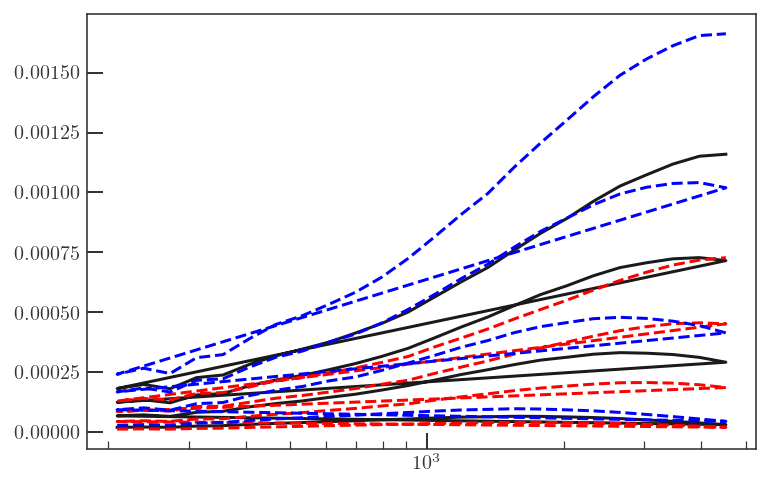

In [10]:
print(params[1], params[2])
mu = interp( (params[1] + params[2])/2. )
mu = np.array(list(mu.tolist())).reshape( len(ell) )

plt.plot(ell,ell*(ell+1)/np.pi * mu, '-')
plt.plot(ell,ell*(ell+1)/np.pi * obsarr[1], 'r--')
plt.plot(ell,ell*(ell+1)/np.pi * obsarr[2], 'b--')
plt.xscale('log')

# Power Spectra
## 1D cross sections
The 1D cross sections are sensibly right on top of our "observation". To make these, we fix the other two parameters at the "observation" (model 1b).

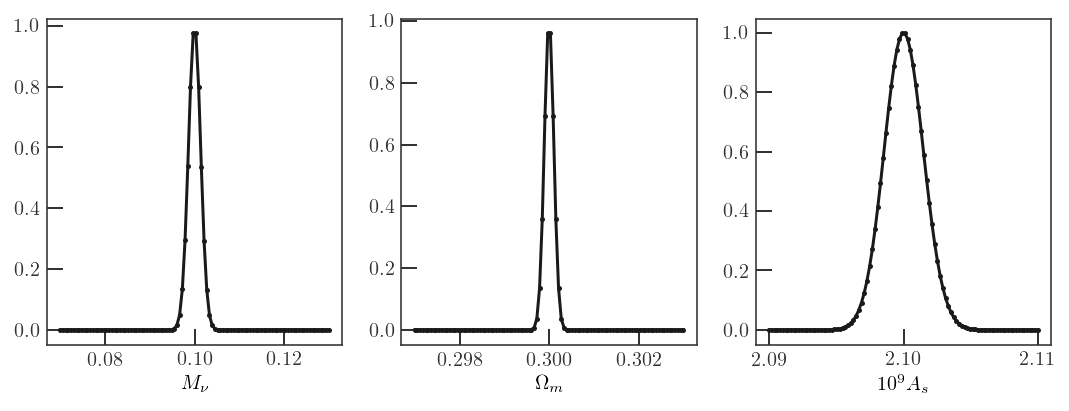

In [11]:
u = np.linspace(0.07, 0.13, 100)
v = np.linspace(0.297, 0.303, 100)
w = np.linspace(2.1-0.01, 2.1+0.01, 100)

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot( u, [P( (p, 0.3, 2.1) ) for p in u] )
ax[0].set_xlabel(r'$M_{\nu}$')
ax[1].plot( v, [P( (0.1, p, 2.1) ) for p in v] )
ax[1].set_xlabel(r'$\Omega_m$')
ax[2].plot( w, [P( (0.1, 0.3, p) ) for p in w] )
ax[2].set_xlabel(r'$10^9A_s$')

# 2D slices
To test the interpolator further, we take 2D slices and fix just 1 parameter at the "observation" value.

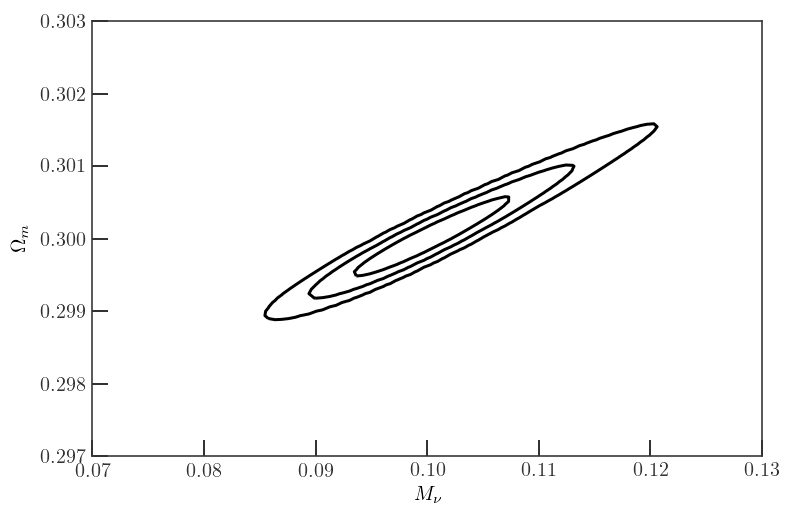

In [12]:
from forecast import findlevel
import matplotlib.cm as cm


fig_M_nu, ax_M_nu = plt.subplots(1)
U, V = np.meshgrid(u, v)
P2 = np.array([P( (x,y,2.1) ) for x,y in zip(np.ravel(U), np.ravel(V))])
P2 = P2.reshape(U.shape)

contour = ax_M_nu.contour(U, V, P2, levels=findlevel(P2)[::-1], \
                     colors=('k', 'k', 'k'), label='Power Spectrum')

ax_M_nu.set_xlabel(r'$M_{\nu}$')
ax_M_nu.set_ylabel(r'$\Omega_m$')

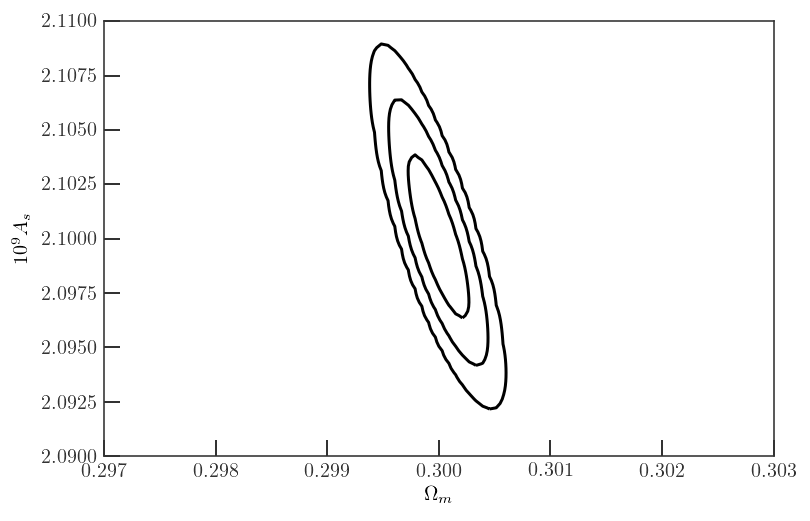

In [13]:


V, W = np.meshgrid(v, w)
P2 = np.array([P( (0.1,x,y) ) for x,y in zip(np.ravel(V), np.ravel(W))])
P2 = P2.reshape(V.shape)

contour = plt.contour(V, W, P2, levels=findlevel(P2)[::-1], \
                     colors=('k', 'k', 'k'))

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$10^9A_s$')

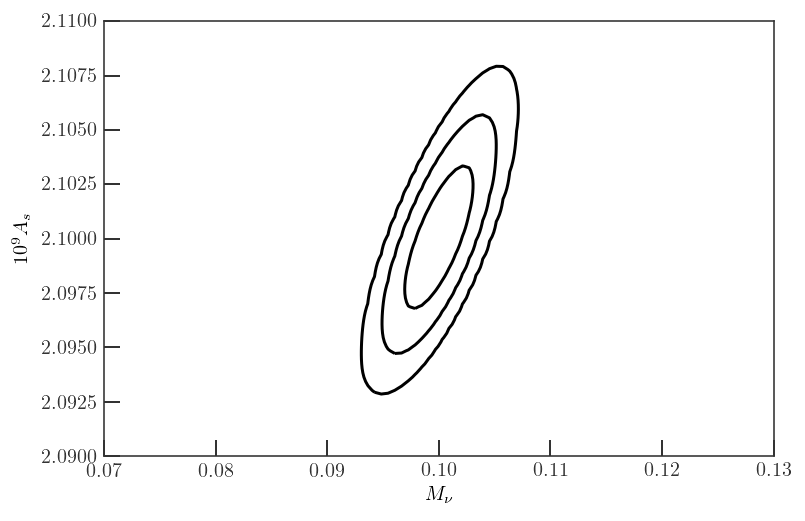

In [14]:
U, W = np.meshgrid(u, w)
P2 = np.array([P( (x,0.3,y) ) for x,y in zip(np.ravel(U), np.ravel(W))])
P2 = P2.reshape(U.shape)

contour = plt.contour(U, W, P2, levels=findlevel(P2)[::-1], \
                     colors=('k', 'k', 'k'))

plt.xlabel(r'$M_{\nu}$')
plt.ylabel(r'$10^9A_s$')

# Marginalizing Over PS To Get Neutrino Mass
I just take the sum over the two axes that aren't neutrino mass.

In [15]:
# u = np.linspace(0.07, 0.13, 30)
# v = np.linspace(0.297, 0.303, 30)
# w = np.linspace(2.1-0.01, 2.1+0.01, 30)


# X, Y, Z = np.meshgrid(u, v, w)
# Ps = np.array([P( (x,y,z) ) for x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))])
# Ps = Ps.reshape(X.shape)

In [16]:
# plt.plot( u, np.sum(np.sum(Ps, axis=2), axis=1) )
# plt.xlabel(r'$M_{\nu}$')
# plt.title('Not Normalized')

# Peak Counts

In [17]:
# WE MULTIPLY THE COVARIANCE BY A MULTIPLIER TO REPLICATE LSST (map size / LSST coverage)

zero_filter = np.logical_not(np.isclose(np.sum( PC_cov, axis=1 ),0.0))
invcov = np.linalg.inv(PC_cov * 12.25/2e4) 


obsarr = np.array( PC_means ) 
interp = buildInterpolator(obsarr, params)

def P( mu ):
    mu = interp( mu )
    mu = np.array(list(mu.tolist())).reshape( len(kappa) ) 
    d = obsarr[1]
    dm = d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(invcov,dm)) )  

## Testing the Interpolator

[ 0.1  0.3  2.1] [ 0.06271  0.3815   2.2004 ]


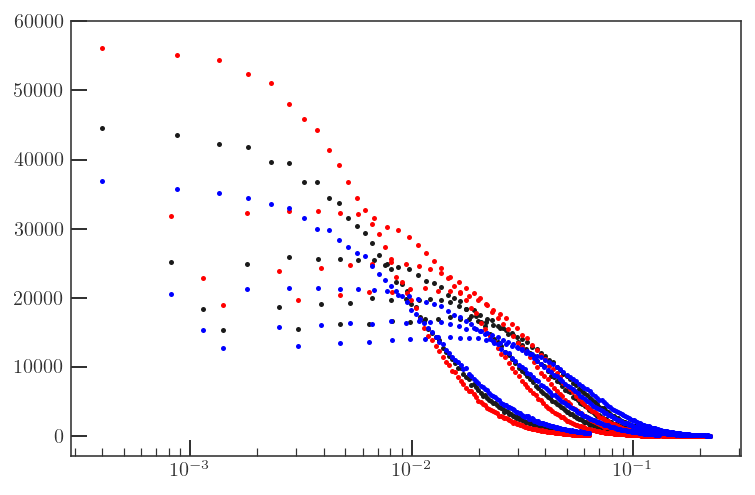

In [18]:
print(params[1], params[2])
mu = interp( (params[1] + params[2])/2. )
mu = np.array(list(mu.tolist())).reshape( len(kappa) )

plt.plot(kappa, mu, '.')
plt.plot(kappa, obsarr[1], 'r.')
plt.plot(kappa, obsarr[2], 'b.')
plt.xscale('log')

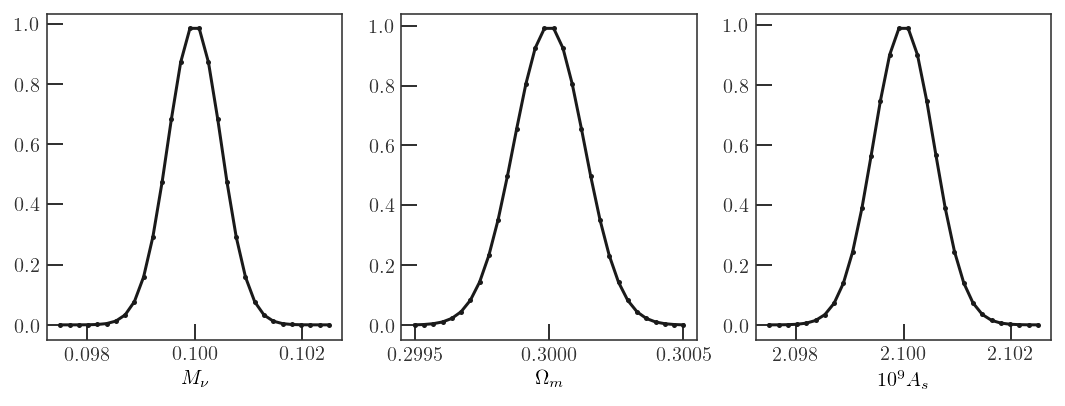

In [19]:
from forecast import findlevel
import matplotlib.cm as cm

u = np.linspace(0.1 - 0.0025, 0.1 + 0.0025, 30)
v = np.linspace(0.3 - 0.0005, 0.3 + 0.0005, 30)
w = np.linspace(2.1-0.0025, 2.1+0.0025, 30)

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot( u, [P( (p, 0.3, 2.1) ) for p in u] )
ax[0].set_xlabel(r'$M_{\nu}$')
ax[1].plot( v, [P( (0.1, p, 2.1) ) for p in v] )
ax[1].set_xlabel(r'$\Omega_m$')
ax[2].plot( w, [P( (0.1, 0.3, p) ) for p in w] )
ax[2].set_xlabel(r'$10^9A_s$')

/Users/zequnl/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


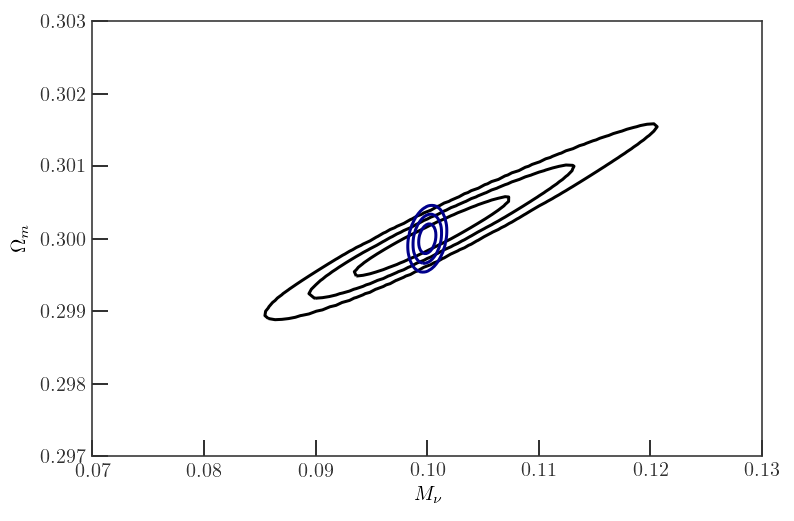

In [20]:

# fig_M_nu, ax_M_nu
U, V = np.meshgrid(u, v)
P2 = np.array([P( (x,y,2.1) ) for x,y in zip(np.ravel(U), np.ravel(V))])
P2 = P2.reshape(U.shape)

ax_M_nu.contour(U, V, P2, levels=findlevel(P2)[::-1], \
                     colors=('darkblue', 'darkblue', 'darkblue'), label='Peak Counts')

ax_M_nu.set_xlabel(r'$M_{\nu}$')
ax_M_nu.set_ylabel(r'$\Omega_m$')

# need these because 
ax_M_nu.plot([],[], '-', label='Power Spectrum', color='black')
ax_M_nu.plot([],[], '-', label='Peak Counts', color='darkblue')
ax_M_nu.legend()

fig_M_nu

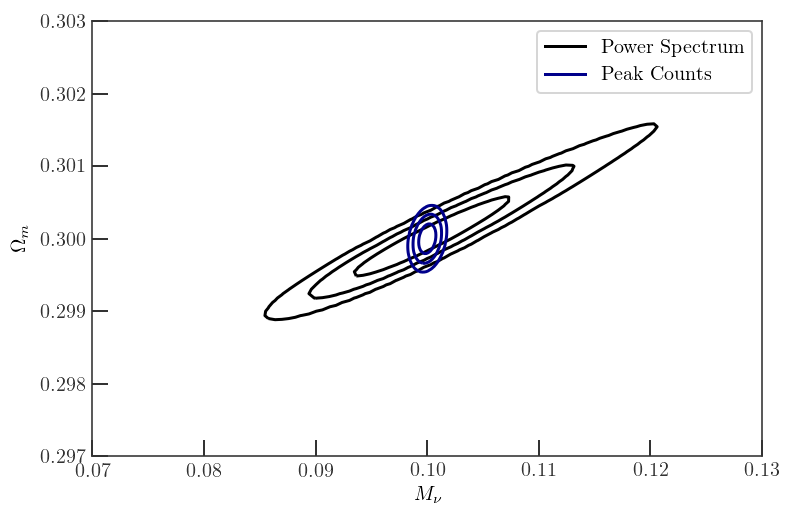

In [22]:
ax_M_nu.plot([],[], '-', label='Power Spectrum', color='black')
ax_M_nu.plot([],[], '-', label='Peak Counts', color='darkblue')
ax_M_nu.legend()

fig_M_nu